--- NO CACHE: Processing raw files for Tumor ---
   --> Found 8 parquet files in Tumor. Processing...



--- Data Stats for Tumor ---
count        8.000000
mean     42168.125000
std       7340.341593
min      27990.000000
25%      39290.500000
50%      42454.000000
75%      47082.750000
max      51270.000000
Name: Unique_CDR3_Count, dtype: float64


/tmp/ipykernel_4104699/303492184.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


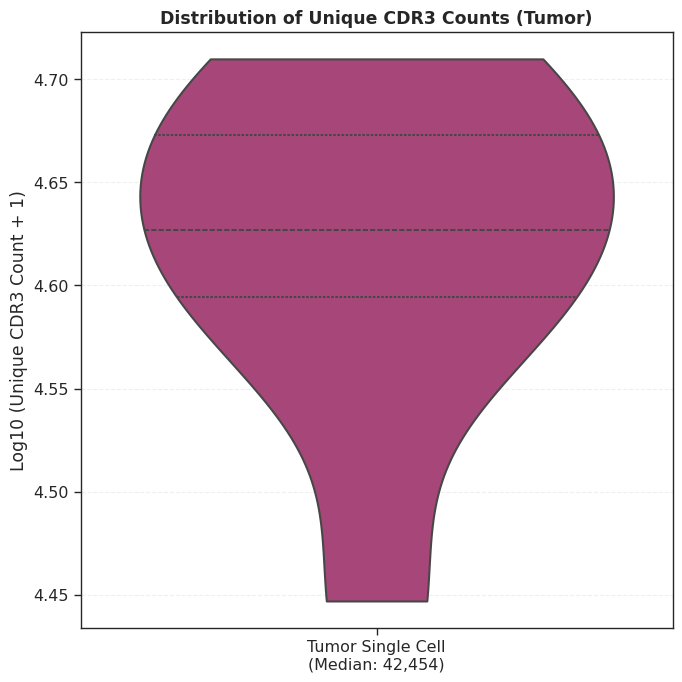

Plot saved to: sc_cdr3_analysis_plots/violin_breast_sc_Tumor.png
Calculated Median: 42454
--- NO CACHE: Processing raw files for LNM ---
   --> Found 8 parquet files in LNM. Processing...

--- Data Stats for LNM ---
count        8.000000
mean     48702.000000
std       5969.348517
min      42173.000000
25%      44607.000000
50%      46705.000000
75%      53353.500000
max      57269.000000
Name: Unique_CDR3_Count, dtype: float64


/tmp/ipykernel_4104699/303492184.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


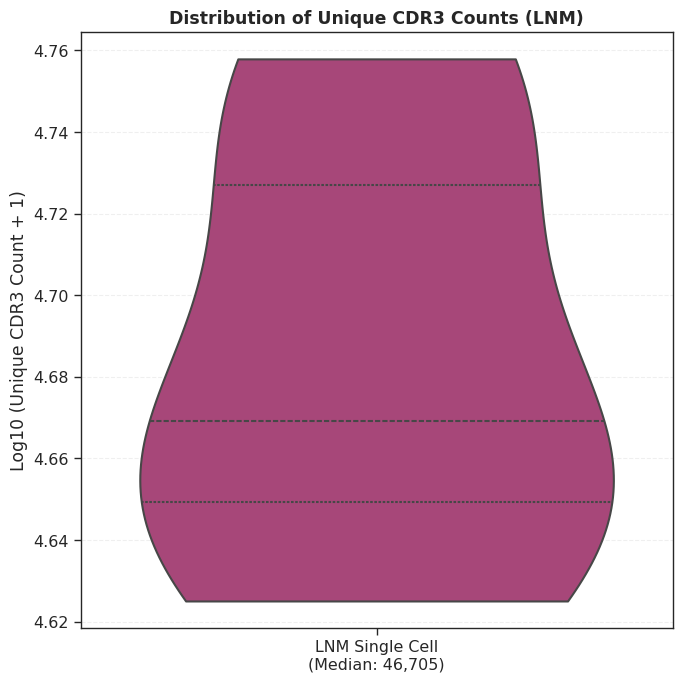

Plot saved to: sc_cdr3_analysis_plots/violin_breast_sc_LNM.png
Calculated Median: 46705

Combined data saved to combined_sc_cdr3_summary.csv


In [23]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================
DATA_PATHS = {
    "Tumor": "/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/Tumor/airrport",
    "LNM": "/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/LNM/airrport"
}

OUTPUT_DIR = "sc_cdr3_analysis_plots" 
FORCE_RELOAD = False 

def analyze_parquet_files(folder_path, tissue_label):
    data_summary = []
    
    if not folder_path or not os.path.exists(folder_path):
        print(f"Error: Path not found: {folder_path}")
        return pd.DataFrame()

    files = glob.glob(os.path.join(folder_path, "*.parquet"))
    print(f"   --> Found {len(files)} parquet files in {tissue_label}. Processing...")

    for filepath in files:
        try:
            df = pd.read_parquet(filepath)
            if "CDR3_match" in df.columns:
                unique_count = df["CDR3_match"].nunique()
                filename = os.path.basename(filepath).replace('.parquet', '')
                data_summary.append({
                    'Sample': filename,
                    'Unique_CDR3_Count': unique_count,
                    'Tissue': tissue_label
                })
        except Exception as e:
            print(f"Error in {os.path.basename(filepath)}: {e}")
            
    return pd.DataFrame(data_summary)

def load_data_smart(folder_path, tissue_label, force=False):
    cache_path = os.path.join(OUTPUT_DIR, f"sc_breast_cache_{tissue_label}.csv")
    
    if os.path.exists(cache_path) and not force:
        print(f"--- CACHE FOUND: Loading {tissue_label} from {cache_path} ---")
        df = pd.read_csv(cache_path)
    else:
        print(f"--- NO CACHE: Processing raw files for {tissue_label} ---")
        df = analyze_parquet_files(folder_path, tissue_label)
        if not df.empty:
            df.to_csv(cache_path, index=False)
    
    return df

def create_violin_plot(df, tissue_label):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    sns.set_theme(style="ticks", context="paper", font_scale=1.3)
    df['Log_Value'] = np.log10(df['Unique_CDR3_Count'] + 1)
    median_val = int(df['Unique_CDR3_Count'].median())

    plt.figure(figsize=(7, 7))
    sns.violinplot(
        data=df,
        x="Tissue",
        y="Log_Value",
        inner="quartile",
        palette="magma",
        cut=0,
        linewidth=1.5
    )

    plt.title(f'Distribution of Unique CDR3 Counts ({tissue_label})', fontweight='bold')
    plt.ylabel('Log10 (Unique CDR3 Count + 1)')
    plt.xlabel('')
    new_label = f"{tissue_label} Single Cell\n(Median: {median_val:,})"
    plt.xticks(ticks=[0], labels=[new_label])
    plt.grid(True, axis='y', ls="--", alpha=0.3)
    plt.tight_layout()
    
    save_path = os.path.join(OUTPUT_DIR, f"violin_breast_sc_{tissue_label}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()  # display in notebook
    plt.close()

    print(f"Plot saved to: {save_path}")
    print(f"Calculated Median: {median_val}")

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    all_dfs = []

    for tissue_label, path in DATA_PATHS.items():
        df = load_data_smart(path, tissue_label, FORCE_RELOAD)
        if not df.empty:
            print(f"\n--- Data Stats for {tissue_label} ---")
            print(df['Unique_CDR3_Count'].describe())
            create_violin_plot(df, tissue_label)
            all_dfs.append(df)
        else:
            print(f"No data found for {tissue_label}. Check your path.")

    # Optional: Combine Tumor + LNM into one dataframe for further analysis
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        combined_df.to_csv(os.path.join(OUTPUT_DIR, "combined_sc_cdr3_summary.csv"), index=False)
        print("\nCombined data saved to combined_sc_cdr3_summary.csv")


In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
from pathlib import Path
import re

# -----------------------------
# METADATA DICTIONARY
# SRX_ID : (Patient_ID, Sample_Type)
# -----------------------------
vdj_metadata = {
    "SRX10124723": ("P1", "tumor"),
    "SRX10124731": ("P1", "LNM"),
    "SRX10124724": ("P2", "tumor"),
    "SRX10124732": ("P2", "LNM"),
    "SRX10124725": ("P3", "tumor"),
    "SRX10124733": ("P3", "LNM"),
    "SRX10124726": ("P4", "tumor"),
    "SRX10124734": ("P4", "LNM"),
    "SRX10124727": ("P5", "tumor"),
    "SRX10124735": ("P5", "LNM"),
    "SRX10124728": ("P6", "tumor"),
    "SRX10124736": ("P6", "LNM"),
    "SRX10124729": ("P7", "tumor"),
    "SRX10124737": ("P7", "LNM"),
    "SRX10124730": ("P8", "tumor"),
    "SRX10124738": ("P8", "LNM")
}

gex_metadata = {
    "SRX10124739": ("P1", "tumor"),
    "SRX10124715": ("P1", "LNM"),
    "SRX10124740": ("P2", "tumor"),
    "SRX10124716": ("P2", "LNM"),
    "SRX10124709": ("P3", "tumor"),
    "SRX10124717": ("P3", "LNM"),
    "SRX10124710": ("P4", "tumor"),
    "SRX10124718": ("P4", "LNM"),
    "SRX10124711": ("P5", "tumor"),
    "SRX10124719": ("P5", "LNM"),
    "SRX10124712": ("P6", "tumor"),
    "SRX10124720": ("P6", "LNM"),
    "SRX10124713": ("P7", "tumor"),
    "SRX10124721": ("P7", "LNM"),
    "SRX10124714": ("P8", "tumor"),
    "SRX10124722": ("P8", "LNM")
}

# -----------------------------
# SMART PATH FUNCTION
# -----------------------------
def get_paths(sample_type):
    """
    Return (vdj_dir, airrport_dir, output_file) depending on sample_type
    """
    if sample_type.lower() == "tumor":
        vdj_dir = Path("/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/Tumor/vdj")
        airrport_dir = Path("/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/Tumor/airrport")
        out_file = "vdj_vs_airrport_shared_summary_Tumor.csv"
    elif sample_type.lower() == "lnm":
        vdj_dir = Path("/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/LNM/vdj")
        airrport_dir = Path("/dsi/efroni-lab/AIRRPORT/singlecell_breast/results/LNM/airrport")
        out_file = "vdj_vs_airrport_shared_summary_LNM.csv"
    else:
        raise ValueError(f"Unknown sample type: {sample_type}")
    return vdj_dir, airrport_dir, out_file

# -----------------------------
# HELPERS
# -----------------------------
def extract_srx(text):
    s = str(text).replace("_vdj", "")
    m = re.search(r"(SRX\d+)", s)
    return m.group(1) if m else None

def load_vdj_data(vdj_dir):
    vdj_dict = {}
    for file in vdj_dir.glob("*_vdj_filtered_contig_annotations.csv"):
        df = pd.read_csv(file)
        if "sample" not in df.columns or "cdr3" not in df.columns:
            raise ValueError(f"'sample' or 'cdr3' column missing in {file}")
        df["SRX_clean"] = df["sample"].apply(extract_srx)
        for srx in df["SRX_clean"].dropna().unique():
            sub = df[df["SRX_clean"] == srx]
            unique_cdr3 = set(sub["cdr3"].dropna().unique())
            vdj_dict.setdefault(srx, set()).update(unique_cdr3)
    return vdj_dict

def load_airrport_data(airrport_dir):
    airr_dict = {}
    for file in airrport_dir.glob("matched_SRX*_unaligned_reads_plusCBUB_trimmed_R2.parquet"):
        srx = extract_srx(file.name)
        if not srx:
            continue
        df = pd.read_parquet(file)
        if "CDR3_match" not in df.columns:
            raise ValueError(f"'CDR3_match' column missing in {file}")
        airr_dict[srx] = set(df["CDR3_match"].dropna().unique())
    return airr_dict

def compare_samples(vdj_dict, airr_dict, vdj_metadata, gex_metadata, sample_type):
    rows = []
    for srx, vdj_seqs in vdj_dict.items():
        # Only process this sample type
        if srx not in vdj_metadata:
            continue
        patient, stype = vdj_metadata[srx]
        if stype.lower() != sample_type.lower():
            continue
        # Find corresponding AIRRPORT SRX
        matching_srx = None
        for airr_srx, (airr_patient, airr_stype) in gex_metadata.items():
            if airr_patient == patient and airr_stype.lower() == sample_type.lower():
                matching_srx = airr_srx
                break
        if matching_srx and matching_srx in airr_dict:
            airr_seqs = airr_dict[matching_srx]
        else:
            airr_seqs = set()
        airr_count = len(airr_seqs)
        vdj_count = len(vdj_seqs)
        shared_count = len(vdj_seqs & airr_seqs)
        rows.append([patient, srx, matching_srx, sample_type, vdj_count, airr_count, shared_count])
    return rows

# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    # Choose sample type: 'Tumor' or 'LNM'
    sample_type = "LNM"  # <-- change here to 'LNM' to process LNM samples

    vdj_dir, airrport_dir, out_file = get_paths(sample_type)

    print(f"Processing {sample_type} samples...")
    vdj_dict = load_vdj_data(vdj_dir)
    airr_dict = load_airrport_data(airrport_dir)
    rows = compare_samples(vdj_dict, airr_dict, vdj_metadata, gex_metadata, sample_type)

    summary = pd.DataFrame(
        rows,
        columns=["Patient_ID", "VDJ_SRX_ID", "AIRRPORT_GEX_SRX_ID", "Sample_Type",
                 "VDJ_unique_CDR3", "AIRRPORT_unique_sequences", "Shared_sequences"]
    )

    summary.to_csv(out_file, index=False)
    print(summary)
    print(f"\nSaved results to: {out_file}")


Processing LNM samples...
  Patient_ID   VDJ_SRX_ID AIRRPORT_GEX_SRX_ID Sample_Type  VDJ_unique_CDR3  \
0         P8  SRX10124738         SRX10124722         LNM             3125   
1         P6  SRX10124736         SRX10124720         LNM            10246   
2         P4  SRX10124734         SRX10124718         LNM            12899   
3         P7  SRX10124737         SRX10124721         LNM             6369   
4         P2  SRX10124732         SRX10124716         LNM            52238   
5         P3  SRX10124733         SRX10124717         LNM             5055   
6         P1  SRX10124731         SRX10124715         LNM             5654   
7         P5  SRX10124735         SRX10124719         LNM             7229   

   AIRRPORT_unique_sequences  Shared_sequences  
0                      47684               357  
1                      56586               812  
2                      45726              2208  
3                      45263               620  
4                      572